# TODO

- refactor code; dataframe manipulation is working, but it's really copy paste heavy

In [85]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import pint

# Load Data

In [184]:
# specify experiment specific data
date = '2021.11.11'
filename = "2021-11-11_QD510nm_vol_series_trimmed.csv"
df = pd.read_csv(filename)

# well, I guesss I'm adding geometry to this sucker
u = pint.UnitRegistry()


# specify (and rename) column to extract
name_map = {
    'Time':'time',
    'A1':'X-blank-1',
    'A2':'X-blank-2',
    'A3':'X-blank-3',
    'A4':'X-blank-4',
    'A5':'X-blank-5',
    'A6':'X-blank-6',
    'A7':'X-blank-7',
    'A8':'X-blank-8',
    'B1':'X-blank-9',
    'B2':'10uL-H20-1',
    'B3':'10uL-exp-1',
    'B4':'10uL-H20-2',
    'B5':'10uL-exp-2',
    'B6':'10uL-H20-3',
    'B7':'10uL-exp-3',
    'B8':'X-blank-10',
    'C1':'X-blank-11',
    'C2':'5uL-H20-1',
    'C3':'5uL-exp-1',
    'C4':'5uL-H20-2',
    'C5':'5uL-exp-2',
    'C6':'5uL-H20-3',
    'C7':'5uL-exp-3',
    'C8':'X-blank-12',
    'D1':'X-blank-13',
    'D2':'2uL-H20-1',
    'D3':'2uL-exp-1',
    'D4':'2uL-H20-2',
    'D5':'2uL-exp-2',
    'D6':'2uL-H20-3',
    'D7':'2uL-exp-3',
    'D8':'X-blank-14',
    'E1':'X-blank-15',
    'E2':'1uL-H20-1',
    'E3':'1uL-exp-1',
    'E4':'1uL-H20-2',
    'E5':'1uL-exp-2',
    'E6':'1uL-H20-3',
    'E7':'1uL-exp-3',
    'E8':'X-blank-16',
    'F1':'X-blank-17',
    'F2':'0.5uL-H20-1',
    'F3':'0.5uL-exp-1',
    'F4':'0.5uL-H20-2',
    'F5':'0.5uL-exp-2',
    'F6':'0.5uL-H20-3',
    'F7':'0.5uL-exp-3',
    'F8':'X-blank-18',
    'G1':'X-blank-19',
    'G2':'X-blank-20',
    'G3':'X-blank-21',
    'G4':'X-blank-22',
    'G5':'X-blank-23',
    'G6':'X-blank-24',
    'G7':'X-blank-25',
    'G8':'X-blank-26',
}

df.rename(columns=name_map, inplace=True); df.drop(columns=['Unnamed: 0', 'Temperature(¡C)'], inplace=True)
df['time'] = pd.to_datetime(df['time']); exp_time = df['time'].values
df.set_index('time', inplace=True); 
# df = df.stack(); df.index.set_names(['time', 'colname'], inplace=True)

# x.index.set_names(['time', 'colname'])
# # df['timestr'] = df['time'].dt.strftime('%H:%M:%S') # setting in hh:mm:ss format

# # get time in integer seconds since start of measurement
# def timestr_to_sec(timestr:str) -> int:
#     h, m, s = timestr.split(':') # in hh:mm:ss format
#     # convert each to int seconds
#     sec_int = int(s)
#     min_int = int(m) * 60
#     hr_int = int(h) * 60**2
    
#     return sec_int + min_int + hr_int

# df['int_time'] = df['timestr'].map(timestr_to_sec)


# make list of dfs to concatenate into final df

time = []; fluorescence = []; volume = []; condition = []; replicate = []
data_dict = {k: [] for k in ['time', 'fluorescence', 'condition', 'volume', 'replicate']}

for colname in name_map.values():
    if colname == 'time':
        continue

    vol, cond, rep = colname.split('-')

    time += [t for t in exp_time]
    fluorescence += [v for v in df[colname]]
    volume += [vol for _ in range(len(exp_time))]
    condition += [cond for _ in range(len(exp_time))]
    replicate += [rep for _ in range(len(exp_time))]
    
    data_dict['time'] += [t for t in exp_time]
    data_dict['fluorescence'] += [v for v in df[colname]]
    data_dict['volume'] += [vol for _ in range(len(exp_time))]
    data_dict['condition'] += [cond for _ in range(len(exp_time))]
    data_dict['replicate'] += [rep for _ in range(len(exp_time))]



ind = pd.MultiIndex.from_arrays(
    [time, condition, volume, replicate],
    names= ['time', 'condition', 'volume', 'replicate']
)
# data = pd.DataFrame(fluorescence, index=ind)
data = pd.DataFrame.from_dict(data_dict)
data.head()

,time,fluorescence,condition,volume,replicate
0,2021-11-15 00:00:00,32610,blank,X,1
1,2021-11-15 00:05:00,36122,blank,X,1
2,2021-11-15 00:10:01,34738,blank,X,1
3,2021-11-15 00:15:01,31210,blank,X,1
4,2021-11-15 00:20:02,34179,blank,X,1


# Normalize Data

In [172]:
experiment = data.loc[data.condition=='exp']
background = data.loc[data.condition=='H20']

vols = ['10uL', '5uL', '2uL', '1uL', '0.5uL']
reps = [str(i+1) for i in range(3)]

bkgrnd_dict = {}
norm_dict = {}

for v in vols:
    # get background signal
    bkgrnd = background.loc[background.volume == v]
    bkgrnd_fluorescence = np.mean([
        bkgrnd.loc[bkgrnd.replicate == r]['fluorescence']
        for r in reps
    ], axis=0)
    bkgrnd_dict[v] = pd.Series(
        data=bkgrnd_fluorescence,
        index=exp_time
    )
    
    # for each experimental replicate, subtract background
    exp = experiment.loc[experiment.volume == v]
    norm_dict[v] = {
        # r: pd.Series(
        #     data=exp.loc[exp.replicate == r]['fluorescence'] - bkgrnd_fluorescence,
        # )
        r: (exp.loc[exp.replicate == r]['fluorescence'] - bkgrnd_fluorescence).set_axis(exp_time)
        for r in reps
    }
    

norm_averaged= pd.DataFrame.from_dict({
    v: pd.concat(
        norm_dict[v].values(), axis=1
    ).mean(axis=1)
    for v in vols
})

# Plots

## Averaged across replicates

Text(0, 0.5, 'Flourescence (log)')

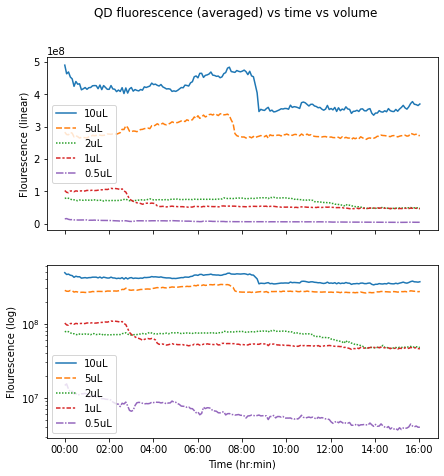

In [183]:
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
date_form = DateFormatter("%H:%M")


for ax in axes:
    sns.lineplot(ax=ax, data=norm_averaged)
    ax.xaxis.set_major_formatter(date_form)
    
    handles, labels = ax.get_legend_handles_labels()
    handle_dict = dict(zip(labels, handles))
    handles = [handle_dict[v] for v in vols]
    ax.legend(handles, vols)

plt.suptitle("QD fluorescence (averaged) vs time vs volume")
plt.xlabel('Time (hr:min)')
axes[0].set_ylabel("Flourescence (linear)")
axes[1].semilogy(); axes[1].set_ylabel("Flourescence (log)")

## All replicates (background subtracted)

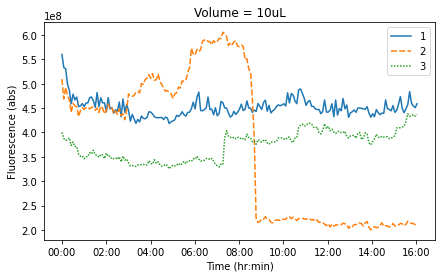

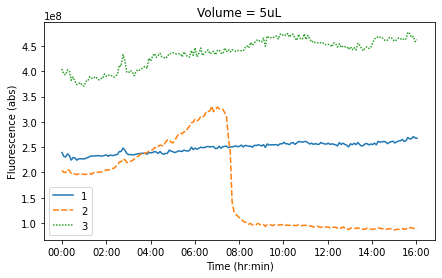

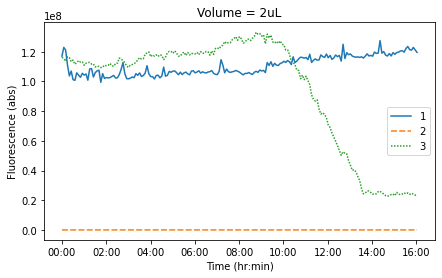

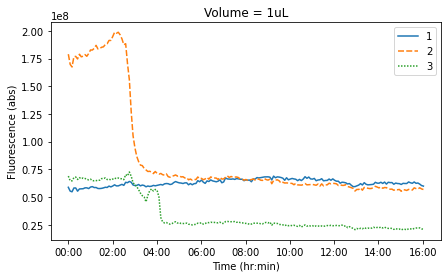

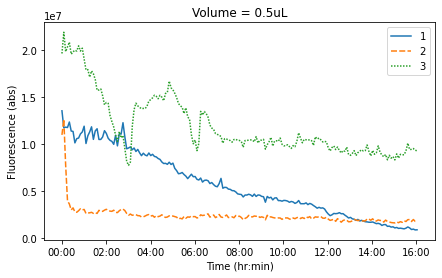

In [182]:
for v in vols:
    f, ax = plt.subplots(figsize=(7, 4))
    sns.lineplot(data=pd.DataFrame.from_dict(norm_dict[v]))
    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.xlabel('Time (hr:min)')
    plt.ylabel('Fluorescence (abs)')
    plt.title(f"Volume = {v}")

# raw

## blanks

In [ ]:
x=data.loc[data['condition']=='blank']

sns.lineplot(
    data=x, x='int_time', y='fluorescence'
)
plt.title('{0}: platereader (timeseries)'.format(date))

ValueError: Could not interpret value `int_time` for parameter `x`

## water

Text(0.5, 1.0, '2021.11.11: platereader (timeseries)')

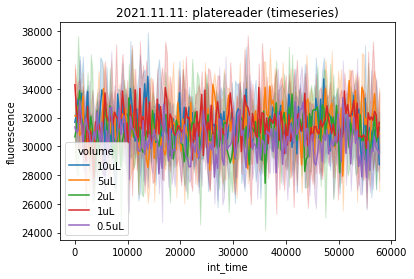

In [9]:
x=data.loc[data['condition']=='H20']

sns.lineplot(
    data=x, x='int_time', y='fluorescence', 
    hue='volume',
)
plt.title('{0}: platereader (timeseries)'.format(date))

## experimental

Text(0.5, 1.0, '2021.11.11: platereader (timeseries)')

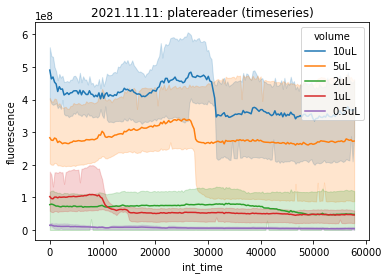

In [10]:
x=data.loc[data['condition']=='exp']

sns.lineplot(
    data=x, x='int_time', y='fluorescence', 
    hue='volume',
)
plt.title('{0}: platereader (timeseries)'.format(date))